In [2]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
# !wget https://www.di.ens.fr/willow/research/seeing3Dchairs/data/rendered_chairs.tar
# !tar -xzf /content/rendered_chairs.tar

In [ ]:
# !apt-get install -y p7zip-full
# !7z e /content/data/celeba/img_align_celeba.zip -o"/content/data/celeba" -y

In [3]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
from tensorboardX import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
if torch.cuda.is_available():
    print(f"Название GPU: {torch.cuda.get_device_name()}")

Используемое устройство: cuda
Название GPU: Tesla T4


In [91]:
class Config:
    def __init__(self, dataset_name="MNIST"):
        self.dataset = dataset_name.upper()

        if self.dataset == "MNIST":
            self.img_size = 28
            self.img_channels = 1
            self.categorical_dim = 10
            self.continuous_dim = 2
            self.noise_dim = 62
            self.batch_size = 128
            self.n_epoch = 100
            self.D_lr = 2e-4
            self.G_lr = 1e-3
            self.lambda_info = 1.0

        elif self.dataset == "FASHION_MNIST":
            self.img_size = 28
            self.img_channels = 1
            self.categorical_dim = 10
            self.continuous_dim = 2
            self.noise_dim = 62
            self.batch_size = 128
            self.n_epoch = 100
            self.D_lr = 2e-4
            self.G_lr = 1e-3
            self.lambda_info = 1.0

        elif self.dataset == "SVHN":
            self.img_size = 32
            self.img_channels = 3
            self.categorical_dim = 40  # 4 × 10
            self.continuous_dim = 4
            self.noise_dim = 124
            self.batch_size = 64
            self.n_epoch = 100
            self.D_lr = 2e-4
            self.G_lr = 1e-3
            self.lambda_info = 1.0

        elif self.dataset == "CELEBA":
            self.img_size = 32
            self.img_channels = 3
            self.categorical_dim = 100  # 10 × 10
            self.continuous_dim = 0
            self.noise_dim = 128
            self.batch_size = 64
            self.n_epoch = 15
            self.D_lr = 2e-4
            self.G_lr = 1e-3
            self.lambda_info = 1.0

        elif self.dataset == "FACES":
            self.img_size = 32
            self.img_channels = 1
            self.categorical_dim = 0
            self.continuous_dim = 5
            self.noise_dim = 128
            self.batch_size = 64
            self.n_epoch = 100
            self.D_lr = 2e-4
            self.G_lr = 5e-4
            self.lambda_info = 0.2

        elif self.dataset == "CHAIRS":
            self.img_size = 64
            self.img_channels = 1
            self.categorical_dim = 60  # 3 × 20
            self.continuous_dim = 1
            self.noise_dim = 128
            self.batch_size = 32
            self.n_epoch = 100
            self.D_lr = 2e-4
            self.G_lr = 1e-3
            self.lambda_info = 1.0

        else:
            raise ValueError(f"Unsupported dataset: {dataset_name}")

        self.latent_dim = self.noise_dim + self.continuous_dim + self.categorical_dim
        self.model_dir = f"models_{self.dataset.lower()}/"
        self.res_dir = f"results_{self.dataset.lower()}/"
        self.log_dir = f"logs_{self.dataset.lower()}/"

        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.res_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

### utils

In [5]:
def sample(config, size, cat_idx=None, cont_vals=None, device='cuda'):
    z = torch.FloatTensor(size, config.noise_dim).uniform_(-1, 1).to(device)

    if config.continuous_dim > 0:
        if cont_vals is not None:
            assert len(cont_vals) == config.continuous_dim
            z_cont = torch.FloatTensor(cont_vals).view(1, -1).repeat(size, 1).to(device)
        else:
            z_cont = torch.FloatTensor(size, config.continuous_dim).uniform_(-1, 1).to(device)
    else:
        z_cont = torch.empty(size, 0, device=device)

    if config.categorical_dim > 0:
        n_codes = config.categorical_dim // 10
        if cat_idx is not None:
            assert len(cat_idx) == n_codes
            z_cat_list = []
            for idx in cat_idx:
                z_cat_one = F.one_hot(
                    torch.full((size,), idx, device=device, dtype=torch.long), 10
                ).float()
                z_cat_list.append(z_cat_one)
            z_cat = torch.cat(z_cat_list, dim=1)
        else:
            z_cat_list = []
            for _ in range(n_codes):
                z_cat_one = F.one_hot(
                    torch.randint(0, 10, (size,), device=device), 10
                ).float()
                z_cat_list.append(z_cat_one)
            z_cat = torch.cat(z_cat_list, dim=1)
    else:
        z_cat = torch.empty(size, 0, device=device)

    return torch.cat([z, z_cont, z_cat], dim=1), z_cont, z_cat

def q_sample(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

def d_loss(real_out, fake_out):
    real_loss = F.binary_cross_entropy_with_logits(real_out, torch.ones_like(real_out))
    fake_loss = F.binary_cross_entropy_with_logits(fake_out, torch.zeros_like(fake_out))
    return real_loss + fake_loss

def g_loss(fake_out):
    return F.binary_cross_entropy_with_logits(fake_out, torch.ones_like(fake_out))

def info_loss(pred_cat, pred_cont_mu, pred_cont_logvar, true_cont, true_cat, config):
    loss = 0.0
    if config.continuous_dim > 0:
        sampled_cont = q_sample(pred_cont_mu, pred_cont_logvar)
        loss += F.mse_loss(sampled_cont, true_cont)
    if config.categorical_dim > 0:
        n_codes = config.categorical_dim // 10
        for i in range(n_codes):
            start = i * 10
            logits = pred_cat[:, start:start+10]
            targets = torch.argmax(true_cat[:, start:start+10], dim=1)
            loss += F.cross_entropy(logits, targets)
    return loss

### Models

In [93]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        in_dim = config.latent_dim
        if config.dataset in ["MNIST", "FASHION_MNIST"]:
            self.main = nn.Sequential(
                nn.Linear(in_dim, 1024), nn.BatchNorm1d(1024), nn.ReLU(True),
                nn.Linear(1024, 7*7*128), nn.BatchNorm1d(7*7*128), nn.ReLU(True),
                nn.Unflatten(1, (128, 7, 7)),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64), nn.ReLU(True),
                nn.ConvTranspose2d(64, config.img_channels, 4, 2, 1, bias=False),
                nn.Tanh()
            )
        elif config.dataset in ["SVHN", "CELEBA"]:
            self.main = nn.Sequential(
                nn.Linear(in_dim, 2*2*448), nn.BatchNorm1d(2*2*448), nn.ReLU(True),
                nn.Unflatten(1, (448, 2, 2)),
                nn.ConvTranspose2d(448, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.ReLU(True),
                nn.ConvTranspose2d(64, config.img_channels, 4, 2, 1, bias=False),
                nn.Tanh()
            )
        elif config.dataset == "FACES":
            self.main = nn.Sequential(
                nn.Linear(in_dim, 1024), nn.BatchNorm1d(1024), nn.ReLU(True),
                nn.Linear(1024, 8*8*128), nn.BatchNorm1d(8*8*128), nn.ReLU(True),
                nn.Unflatten(1, (128, 8, 8)),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
                nn.ConvTranspose2d(64, config.img_channels, 4, 2, 1, bias=False),
                nn.Sigmoid()
            )
        elif config.dataset == "CHAIRS":
            self.main = nn.Sequential(
                nn.Linear(in_dim, 1024), nn.BatchNorm1d(1024), nn.ReLU(True),
                nn.Linear(1024, 8*8*256), nn.BatchNorm1d(8*8*256), nn.ReLU(True),
                nn.Unflatten(1, (256, 8, 8)),
                nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
                nn.ConvTranspose2d(256, 256, 4, 1, 0, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
                nn.ConvTranspose2d(256, 256, 4, 1, 0, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
                nn.ConvTranspose2d(64, config.img_channels, 4, 2, 1, bias=False),
                nn.Sigmoid()
            )
    def forward(self, x):
        return self.main(x)

class SharedFeatureExtractor(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.dataset in ["MNIST", "FASHION_MNIST"]:
            self.conv = nn.Sequential(
                nn.Conv2d(config.img_channels, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Flatten(),
                nn.Linear(128*7*7, 1024),
                nn.BatchNorm1d(1024),
                nn.LeakyReLU(0.1, inplace=True)
            )
            self.feature_dim = 1024
        elif config.dataset in ["SVHN", "CELEBA", "FACES"]:
            self.conv = nn.Sequential(
                nn.Conv2d(config.img_channels, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Flatten(),
                nn.Linear(256*4*4, 1024),
                nn.BatchNorm1d(1024),
                nn.LeakyReLU(0.1, inplace=True)
            )
            self.feature_dim = 1024
        elif config.dataset == "CHAIRS":
            self.conv = nn.Sequential(
                nn.Conv2d(config.img_channels, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(256, 256, 4, 1, 0, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(256, 256, 4, 1, 0, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Flatten(),
                nn.Linear(256*4*4, 1024),
                nn.BatchNorm1d(1024),
                nn.LeakyReLU(0.1, inplace=True)
            )
            self.feature_dim = 1024
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.shared = SharedFeatureExtractor(config)
        self.adv_head = nn.Linear(self.shared.feature_dim, 1)
    def forward(self, x):
        features = self.shared(x)
        out = self.adv_head(features)
        return out, features

class AuxiliaryNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.feature_dim = SharedFeatureExtractor(config).feature_dim
        self.head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.cat_out = nn.Linear(128, config.categorical_dim) if config.categorical_dim > 0 else None
        if config.continuous_dim > 0:
            self.cont_mu = nn.Linear(128, config.continuous_dim)
            self.cont_logvar = nn.Linear(128, config.continuous_dim)
        else:
            self.cont_mu = self.cont_logvar = None
    def forward(self, features):
        h = self.head(features)
        cat = self.cat_out(h) if self.cat_out is not None else None
        mu = self.cont_mu(h) if self.cont_mu is not None else None
        logvar = self.cont_logvar(h) if self.cont_logvar is not None else None
        return cat, mu, logvar

### dataset processing

In [89]:
def get_transforms(config):
    if config.img_channels == 1:
        return transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        return transforms.Compose([
            transforms.Resize(config.img_size),
            transforms.CenterCrop(config.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

def get_dataloader(config):
    if config.dataset == "MNIST":
        ds = datasets.MNIST(root='./data', train=True, download=True, transform=get_transforms(config))
    elif config.dataset == "FASHION_MNIST":
        ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=get_transforms(config))
    elif config.dataset == "SVHN":
        ds = datasets.SVHN(root='./data', split='train', download=True, transform=get_transforms(config))
    elif config.dataset == "CELEBA":
        ds = datasets.CelebA(root='/content/data', split='train', download=False)
    elif config.dataset == "FACES":
        ds = datasets.Omniglot(root='./data', background=True, download=True, transform=get_transforms(config))
    elif config.dataset == "CHAIRS":
        ds = datasets.ImageFolder(root='./data/chairs64', transform=get_transforms(config))
    else:
        raise ValueError()
    return DataLoader(ds, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)

### training utils

In [8]:
def train_display_img(G, config, epoch, step, device):
    G.eval()
    with torch.no_grad():
        n_row = 5
        if config.categorical_dim > 0:
            n_codes = config.categorical_dim // 10
            cat_indices = [[i % 10 for _ in range(n_codes)] for i in range(n_row)]
        else:
            cat_indices = [None] * n_row

        images = []
        for i in range(n_row):
            noise, _, _ = sample(config, n_row, cat_idx=cat_indices[i], device=device)
            fake = G(noise)
            images.append(fake)

        grid = torch.cat(images, dim=0)
        grid = (grid + 1) / 2
        grid = vutils.make_grid(grid, nrow=n_row, padding=2, normalize=False)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)),
                   cmap='gray' if config.img_channels == 1 else None)
        plt.axis('off')
        plt.savefig(f"{config.res_dir}/img_{epoch:04d}_{step:04d}.png", bbox_inches='tight')
        plt.close()
    G.train()

def train(config):
    writer = SummaryWriter(config.log_dir)
    G = Generator(config).to(device)
    D = Discriminator(config).to(device)
    Q = AuxiliaryNetwork(config).to(device)
    G.apply(weights_init); D.apply(weights_init); Q.apply(weights_init)

    if torch.cuda.device_count() > 1:
        G, D, Q = nn.DataParallel(G), nn.DataParallel(D), nn.DataParallel(Q)

    g_opt = optim.Adam(list(G.parameters()) + list(Q.parameters()), lr=config.G_lr, betas=(0.5, 0.999))
    d_opt = optim.Adam(D.parameters(), lr=config.D_lr, betas=(0.5, 0.999))

    loader = get_dataloader(config)
    print(f"Загружено {len(loader.dataset)} изображений ({config.dataset})")
    step = 0

    for epoch in range(config.n_epoch):
        G.train(); D.train(); Q.train()
        losses = {'G': [], 'D': [], 'Info': []}
        pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{config.n_epoch}')

        for real_imgs, _ in pbar:
            real_imgs = real_imgs.to(device)
            bsz = real_imgs.size(0)

            # Train D
            d_opt.zero_grad()
            noise, z_cont, z_cat = sample(config, bsz, device=device)
            with torch.no_grad():
                fake_imgs = G(noise)
            real_out, _ = D(real_imgs)
            fake_out, _ = D(fake_imgs)
            d_loss_val = d_loss(real_out, fake_out)
            d_loss_val.backward()
            d_opt.step()

            # Train G+Q
            g_opt.zero_grad()
            noise, z_cont, z_cat = sample(config, bsz, device=device)
            fake_imgs = G(noise)
            fake_out, feat = D(fake_imgs)
            cat_pred, cont_mu, cont_logvar = Q(feat)

            g_loss_val = g_loss(fake_out)
            i_loss = info_loss(cat_pred, cont_mu, cont_logvar, z_cont, z_cat, config)
            total_g = g_loss_val + config.lambda_info * i_loss
            total_g.backward()
            g_opt.step()

            losses['G'].append(g_loss_val.item())
            losses['D'].append(d_loss_val.item())
            losses['Info'].append(i_loss.item())
            step += 1

            if step % 100 == 0:
                train_display_img(G, config, epoch+1, step, device)
                writer.add_scalar('Loss/G', g_loss_val, step)
                writer.add_scalar('Loss/D', d_loss_val, step)
                writer.add_scalar('Loss/Info', i_loss, step)

            pbar.set_postfix({k: f"{np.mean(v[-10:]):.4f}" for k, v in losses.items()})

        torch.save(G.state_dict(), f"{config.model_dir}/G_epoch_{epoch+1}.pth")
        torch.save(D.state_dict(), f"{config.model_dir}/D_epoch_{epoch+1}.pth")
        torch.save(Q.state_dict(), f"{config.model_dir}/Q_epoch_{epoch+1}.pth")

    writer.close()
    print("Обучение завершено!")

In [23]:
def visualize_trained_generator(dataset_name, epoch=5):
    config = Config(dataset_name)

    # Загрузка генератора
    G = Generator(config).to(device)
    G.load_state_dict(torch.load(f"{config.model_dir}/G_epoch_{epoch}.pth", map_location=device))
    G.eval()

    # Определение меток (если есть)
    if dataset_name.upper() in ["MNIST", "FASHION_MNIST"]:
        labels = [
            "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"
        ] if dataset_name.upper() == "MNIST" else [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        num_classes = 10
    elif dataset_name.upper() == "SVHN":
        labels = [str(i) for i in range(10)]
        num_classes = 10
    elif dataset_name.upper() == "CELEBA":
        # CelebA: 10 дискретных кодов по 10D → показываем 10 вариаций одного "кода"
        labels = [f"Style {i}" for i in range(10)]
        num_classes = 10
    elif dataset_name.upper() == "FACES":
        # Нет дискретных кодов — генерируем 10 случайных
        labels = [f"Face {i+1}" for i in range(10)]
        num_classes = 10
    elif dataset_name.upper() == "CHAIRS":
        labels = [f"Chair {i+1}" for i in range(10)]
        num_classes = 10
    else:
        labels = [f"Sample {i+1}" for i in range(10)]
        num_classes = 10

    # Создание сетки
    cols = 5
    rows = (num_classes + cols - 1) // cols
    plt.figure(figsize=(cols * 2.5, rows * 2.8))

    with torch.no_grad():
        for i in range(num_classes):
            if config.categorical_dim > 0:
                n_codes = config.categorical_dim // 10
                cat_idx = [i % 10] * n_codes  # повторяем один класс по всем кодам
                noise, _, _ = sample(config, 1, cat_idx=cat_idx, device=device)
            else:
                # Нет дискретного кода — генерируем случайное изображение
                noise, _, _ = sample(config, 1, device=device)

            fake = G(noise)
            img = (fake[0].cpu() + 1) / 2  # [-1,1] → [0,1]
            img = torch.clamp(img, 0, 1)

            plt.subplot(rows, cols, i + 1)
            if config.img_channels == 1:
                plt.imshow(img.squeeze(), cmap='gray')
            else:
                plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            plt.title(labels[i], fontsize=11)
            plt.axis('off')

    plt.tight_layout()
    output_path = f"generated_{dataset_name.lower()}_epoch_{epoch}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Сохранено: {output_path}")

In [48]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

def visualize_saved_results(dataset_name, epoch=None, step=None, latest=True):
    """
    Отображает сохранённое изображение из папки results_{dataset_name}.
    Можно указать точную эпоху/шаг или взять последнее.
    """
    res_dir = Path(f"/content/results_{dataset_name.lower()}")

    if not res_dir.exists():
        raise FileNotFoundError(f"Папка результатов не найдена: {res_dir}")

    # Получаем список всех изображений вида img_XXXX_YYYY.png
    img_files = sorted(res_dir.glob("img_*.png"))

    if not img_files:
        raise FileNotFoundError(f"Нет сохранённых изображений в {res_dir}")

    if latest:
        target_img = img_files[-1]  # самое последнее
    else:
        # Ищем по эпохе и шагу
        target_name = f"img_{epoch:04d}_{step:04d}.png"
        target_img = res_dir / target_name
        if not target_img.exists():
            raise FileNotFoundError(f"Изображение не найдено: {target_img}")

    # Загружаем и отображаем
    img = Image.open(target_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


### Fashion MNIST

In [36]:
dataset_name = "FASHION_MNIST"
config = Config(dataset_name)
train(config)

Загружено 60000 изображений (FASHION_MNIST)


Epoch 100/100: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s, G=3.9082, D=0.2410, Info=0.0489]


Обучение завершено!


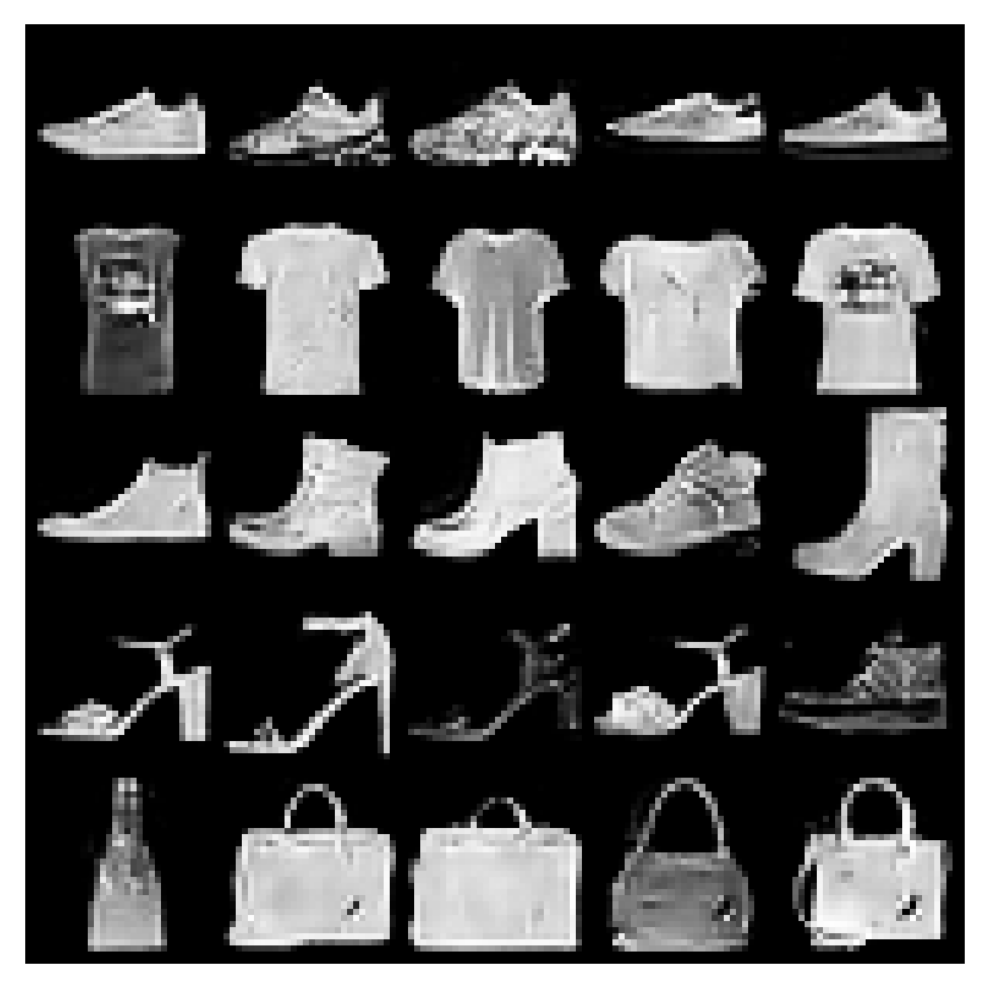

In [57]:
visualize_saved_results("FASHION_MNIST", epoch=99, step=46300, latest=False)

### MNIST

In [38]:
dataset_name = "MNIST"
config = Config(dataset_name)
train(config)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.59MB/s]


Загружено 60000 изображений (MNIST)


Epoch 100/100: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s, G=3.8977, D=0.3040, Info=0.0516]


Обучение завершено!


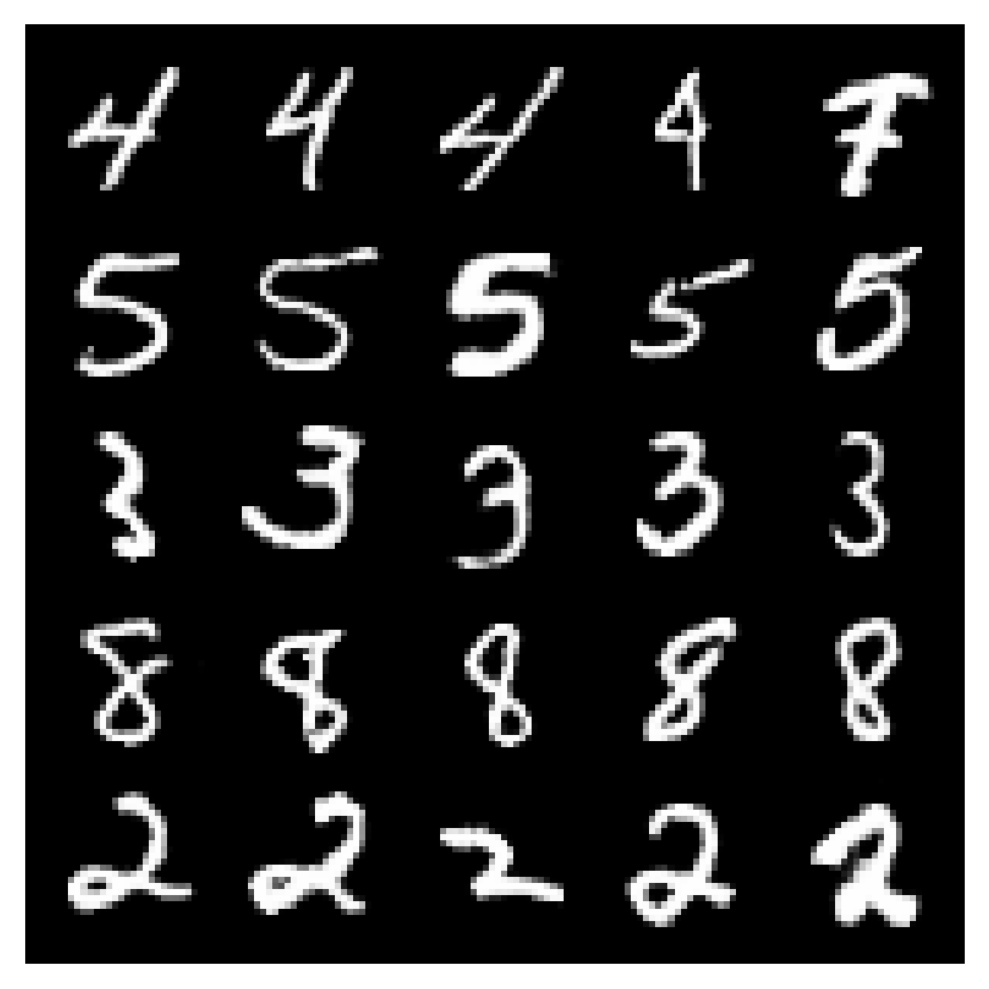

In [60]:
visualize_saved_results("MNIST", epoch=99, step=46200, latest=False)

### SVHN

In [66]:
dataset_name = "SVHN"
config = Config(dataset_name)
train(config)

Загружено 73257 изображений (SVHN)


Epoch 100/100: 100%|██████████| 1145/1145 [00:46<00:00, 24.59it/s, G=12.4912, D=0.0003, Info=0.5971]

Обучение завершено!


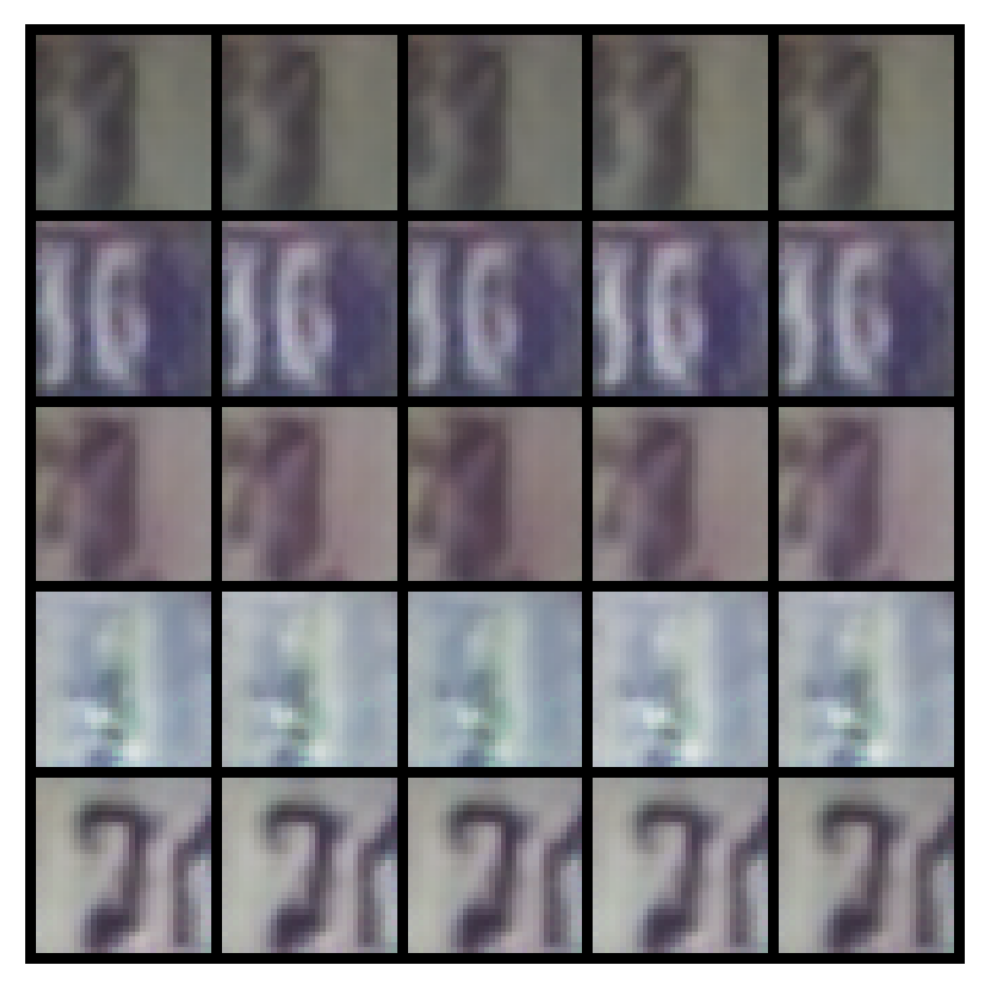

In [69]:
visualize_saved_results("SVHN", epoch=40, step=44700, latest=False)

### CelebA

In [78]:
dataset_name = "CELEBA"
config = Config(dataset_name)
train(config)

Загружено 162770 изображений (CELEBA)


Epoch 15/15: 100%|██████████| 2544/2544 [03:10<00:00, 13.32it/s, G=14.3599, D=0.2765, Info=1.2908]


Обучение завершено!


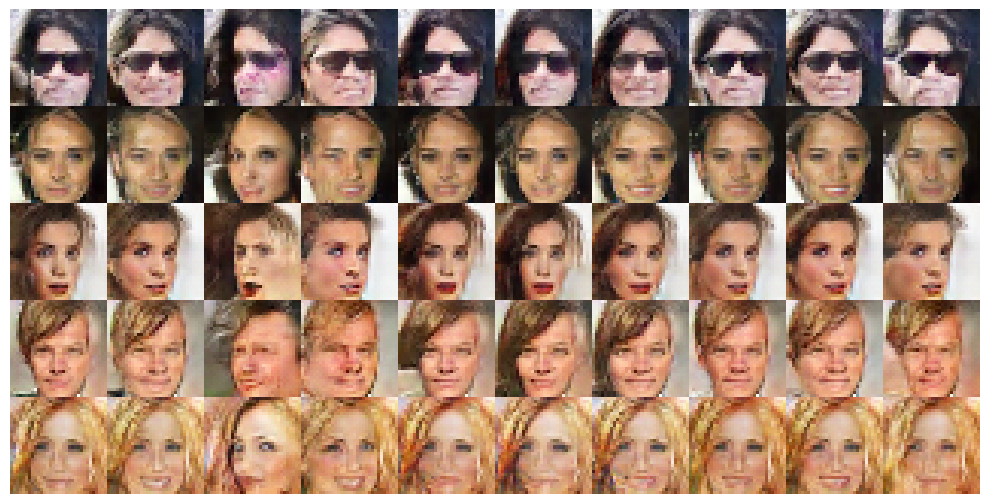

In [80]:
visualize_saved_results("CELEBA", epoch=15, step=39000, latest=False)

### Faces

In [82]:
dataset_name = "FACES"
config = Config(dataset_name)
train(config)

Загружено 19280 изображений (FACES)


Epoch 150/150: 100%|██████████| 302/302 [00:14<00:00, 20.36it/s, G=10.5891, D=0.0189, Info=0.3300]


Обучение завершено!


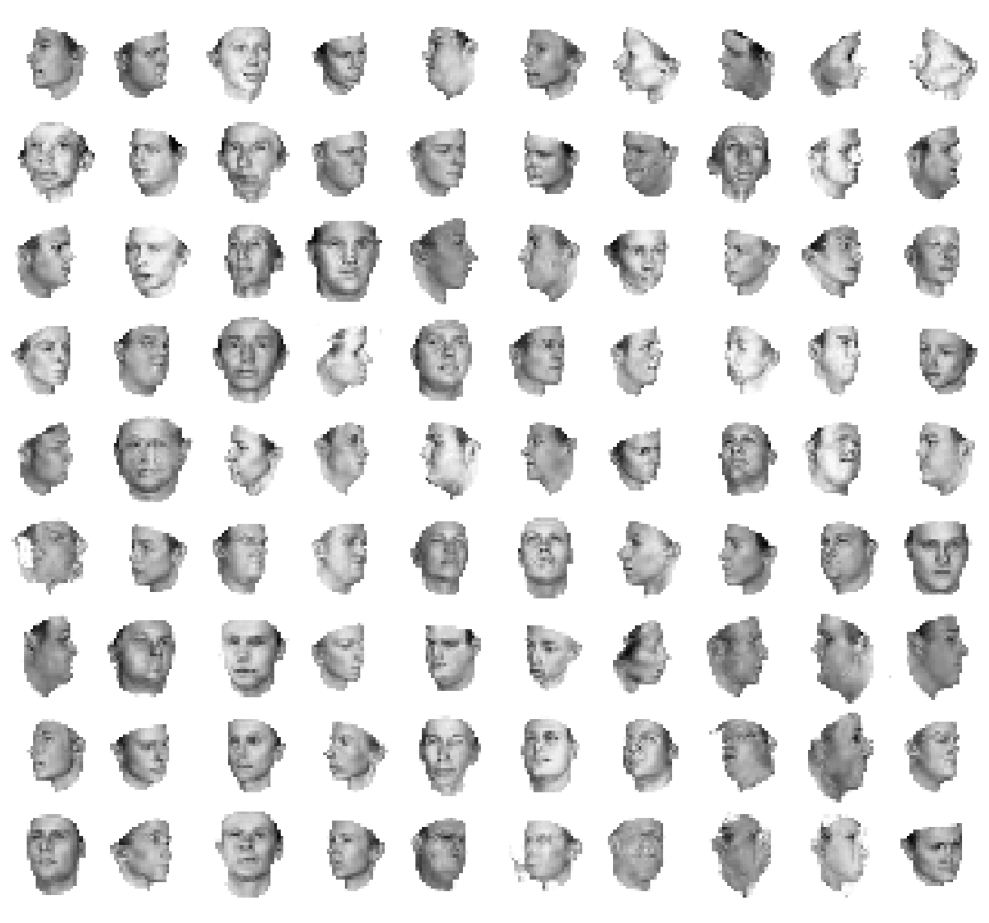

In [83]:
visualize_saved_results("FACES", epoch=150, step=46000, latest=False)

### Chairs

In [94]:
dataset_name = "CHAIRS"
config = Config(dataset_name)
train(config)

Загружено 60000 изображений (CHAIRS)


Epoch 100/100: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s, G=3.8580, D=0.3077, Info=0.0563]

Обучение завершено!


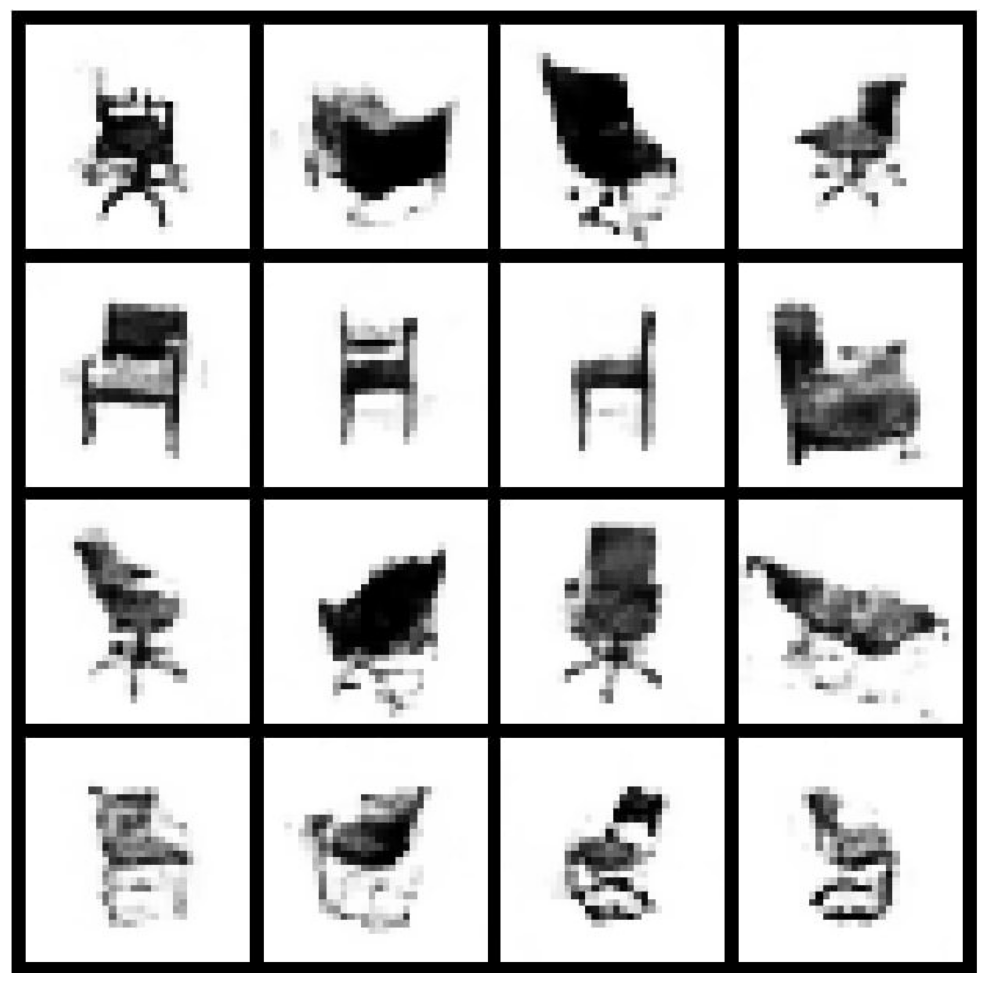

In [88]:
visualize_saved_results("CHAIRS", epoch=100, step=46600, latest=False)